Epoch 1/20 - Train Loss: 11.1405, MAE: 1.3087, RMSE: 3.3377 - Val Loss: 2.8464, MAE: 1.2550, RMSE: 1.6871
Epoch 2/20 - Train Loss: 0.8021, MAE: 0.5734, RMSE: 0.8956 - Val Loss: 0.5625, MAE: 0.5678, RMSE: 0.7500
Epoch 3/20 - Train Loss: 0.2108, MAE: 0.3251, RMSE: 0.4591 - Val Loss: 0.0775, MAE: 0.2093, RMSE: 0.2785
Epoch 4/20 - Train Loss: 0.0793, MAE: 0.1995, RMSE: 0.2816 - Val Loss: 0.0439, MAE: 0.1369, RMSE: 0.2095
Epoch 5/20 - Train Loss: 0.0421, MAE: 0.1336, RMSE: 0.2051 - Val Loss: 0.0386, MAE: 0.1211, RMSE: 0.1964
Epoch 6/20 - Train Loss: 0.0355, MAE: 0.1164, RMSE: 0.1884 - Val Loss: 0.0322, MAE: 0.1050, RMSE: 0.1793
Epoch 7/20 - Train Loss: 0.0322, MAE: 0.1080, RMSE: 0.1795 - Val Loss: 0.0320, MAE: 0.1087, RMSE: 0.1788
Epoch 8/20 - Train Loss: 0.0320, MAE: 0.1064, RMSE: 0.1788 - Val Loss: 0.0406, MAE: 0.1222, RMSE: 0.2016
Epoch 9/20 - Train Loss: 0.0308, MAE: 0.1030, RMSE: 0.1756 - Val Loss: 0.0291, MAE: 0.0958, RMSE: 0.1706
Epoch 10/20 - Train Loss: 0.0269, MAE: 0.0940, RMSE: 0

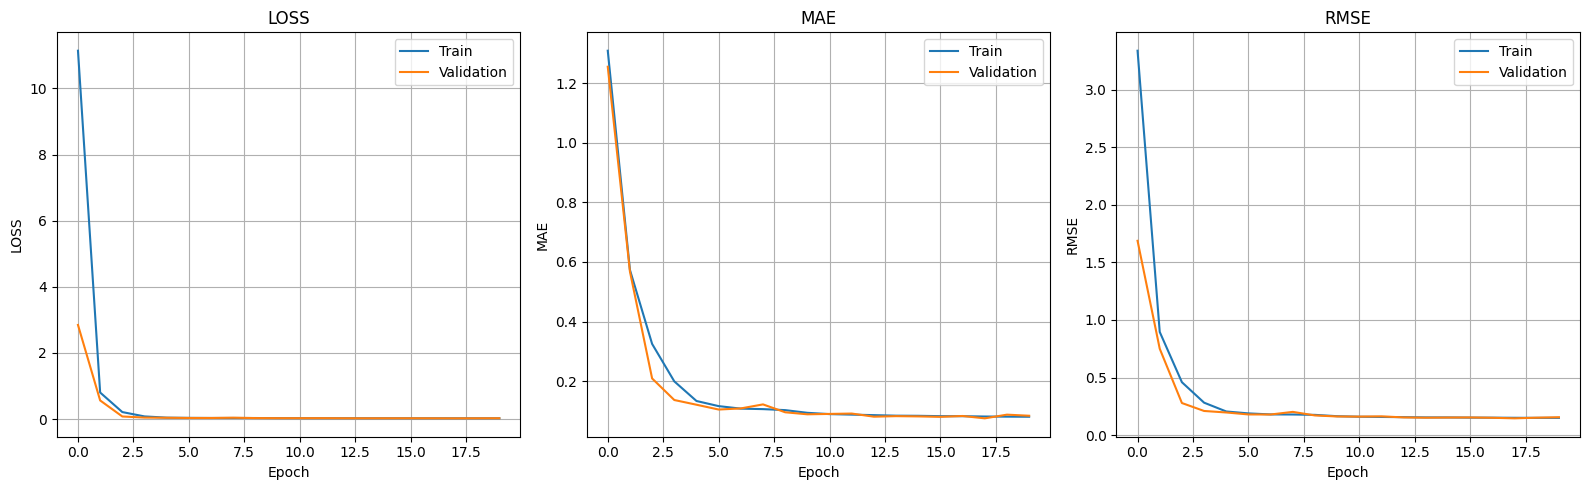

✅ Model saved as 'torcs_mlp_model.pth'


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# === Step 1: Load & Clean Data ===
df = pd.read_csv("Dataset.csv", low_memory=False)

# Strip column names (important!)
df.columns = df.columns.str.strip()

# Define target and feature columns
y_columns = ["Acceleration", "Braking", "Clutch", "Gear", "Steering"]
X_columns = [col for col in df.columns if col not in y_columns]

# Convert values to numeric, coercing errors to NaN
df[X_columns] = df[X_columns].apply(pd.to_numeric, errors='coerce')
df[y_columns] = df[y_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with any missing values
df = df.dropna()

# Convert to PyTorch tensors
X = torch.tensor(df[X_columns].values, dtype=torch.float32)
y = torch.tensor(df[y_columns].values, dtype=torch.float32)

# === Step 2: DataLoaders ===
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

# === Step 3: MLP Model ===
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X.shape[1], output_dim=len(y_columns))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === Step 4: Training with Metrics ===
EPOCHS = 20
history = {
    'train_loss': [], 'val_loss': [],
    'train_mae': [], 'val_mae': [],
    'train_rmse': [], 'val_rmse': []
}

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_mae = 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae += F.l1_loss(pred, yb).item()

    model.eval()
    val_loss, val_mae = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
            val_mae += F.l1_loss(pred, yb).item()

    train_rmse = (train_loss / len(train_loader))**0.5
    val_rmse = (val_loss / len(val_loader))**0.5

    # Save metrics
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(val_loader))
    history['train_mae'].append(train_mae / len(train_loader))
    history['val_mae'].append(val_mae / len(val_loader))
    history['train_rmse'].append(train_rmse)
    history['val_rmse'].append(val_rmse)

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {history['train_loss'][-1]:.4f}, MAE: {history['train_mae'][-1]:.4f}, RMSE: {train_rmse:.4f} - "
          f"Val Loss: {history['val_loss'][-1]:.4f}, MAE: {history['val_mae'][-1]:.4f}, RMSE: {val_rmse:.4f}")

# === Step 5: Plot Metrics ===
plt.figure(figsize=(16, 5))
for i, metric in enumerate(['loss', 'mae', 'rmse']):
    plt.subplot(1, 3, i + 1)
    plt.plot(history[f'train_{metric}'], label='Train')
    plt.plot(history[f'val_{metric}'], label='Validation')
    plt.title(metric.upper())
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# === Step 6: Save Model ===
torch.save(model.state_dict(), "torcs_mlp_model.pth")
print("✅ Model saved as 'torcs_mlp_model.pth'")


In [4]:
# === Step 7: Find Best Epoch (Lowest Val Loss or MAE) ===
best_idx_loss = history['val_loss'].index(min(history['val_loss']))
best_idx_mae = history['val_mae'].index(min(history['val_mae']))

print(f"\n📊 Best Epoch by Val Loss: Epoch {best_idx_loss+1}")
print(f"   Val Loss: {history['val_loss'][best_idx_loss]:.4f}, "
      f"Val MAE: {history['val_mae'][best_idx_loss]:.4f}, "
      f"Val RMSE: {history['val_rmse'][best_idx_loss]:.4f}")

print(f"\n📊 Best Epoch by Val MAE: Epoch {best_idx_mae+1}")
print(f"   Val Loss: {history['val_loss'][best_idx_mae]:.4f}, "
      f"Val MAE: {history['val_mae'][best_idx_mae]:.4f}, "
      f"Val RMSE: {history['val_rmse'][best_idx_mae]:.4f}")



📊 Best Epoch by Val Loss: Epoch 18
   Val Loss: 0.0212, Val MAE: 0.0754, Val RMSE: 0.1455

📊 Best Epoch by Val MAE: Epoch 18
   Val Loss: 0.0212, Val MAE: 0.0754, Val RMSE: 0.1455


In [5]:
# === Step 8: Final Evaluation on Train and Validation Sets ===

def evaluate(loader, name="Dataset"):
    model.eval()
    total_loss, total_mae = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            total_loss += loss.item()
            total_mae += F.l1_loss(pred, yb).item()

    avg_loss = total_loss / len(loader)
    avg_mae = total_mae / len(loader)
    avg_rmse = avg_loss ** 0.5

    print(f"\n📊 Evaluation on {name}")
    print(f"   MSE Loss : {avg_loss:.4f}")
    print(f"   MAE      : {avg_mae:.4f}")
    print(f"   RMSE     : {avg_rmse:.4f}")

# Evaluate on both
evaluate(train_loader, name="Train Set")
evaluate(val_loader, name="Validation Set")



📊 Evaluation on Train Set
   MSE Loss : 0.0235
   MAE      : 0.0829
   RMSE     : 0.1531

📊 Evaluation on Validation Set
   MSE Loss : 0.0241
   MAE      : 0.0841
   RMSE     : 0.1552


BESTTT ONE SO FAR

Epoch 1/20 - Train Loss: 22.6115, MAE: 1.4863, RMSE: 4.7552, R2: -8.5346 - Val Loss: 0.5176, MAE: 0.5655, RMSE: 0.7194, R2: 0.7735
Epoch 2/20 - Train Loss: 1.1611, MAE: 0.6952, RMSE: 1.0775, R2: 0.4948 - Val Loss: 1.1362, MAE: 0.8459, RMSE: 1.0659, R2: 0.5040
Epoch 3/20 - Train Loss: 0.3454, MAE: 0.3965, RMSE: 0.5877, R2: 0.8496 - Val Loss: 0.1298, MAE: 0.2771, RMSE: 0.3603, R2: 0.9431
Epoch 4/20 - Train Loss: 0.1112, MAE: 0.2398, RMSE: 0.3334, R2: 0.9515 - Val Loss: 0.0939, MAE: 0.2306, RMSE: 0.3064, R2: 0.9589
Epoch 5/20 - Train Loss: 0.0507, MAE: 0.1541, RMSE: 0.2252, R2: 0.9778 - Val Loss: 0.0466, MAE: 0.1431, RMSE: 0.2159, R2: 0.9795
Epoch 6/20 - Train Loss: 0.0367, MAE: 0.1191, RMSE: 0.1917, R2: 0.9839 - Val Loss: 0.0336, MAE: 0.1159, RMSE: 0.1833, R2: 0.9852
Epoch 7/20 - Train Loss: 0.0322, MAE: 0.1080, RMSE: 0.1794, R2: 0.9859 - Val Loss: 0.0288, MAE: 0.1004, RMSE: 0.1697, R2: 0.9873
Epoch 8/20 - Train Loss: 0.0288, MAE: 0.0989, RMSE: 0.1696, R2: 0.9874 - Val Loss: 0.0250, MAE:

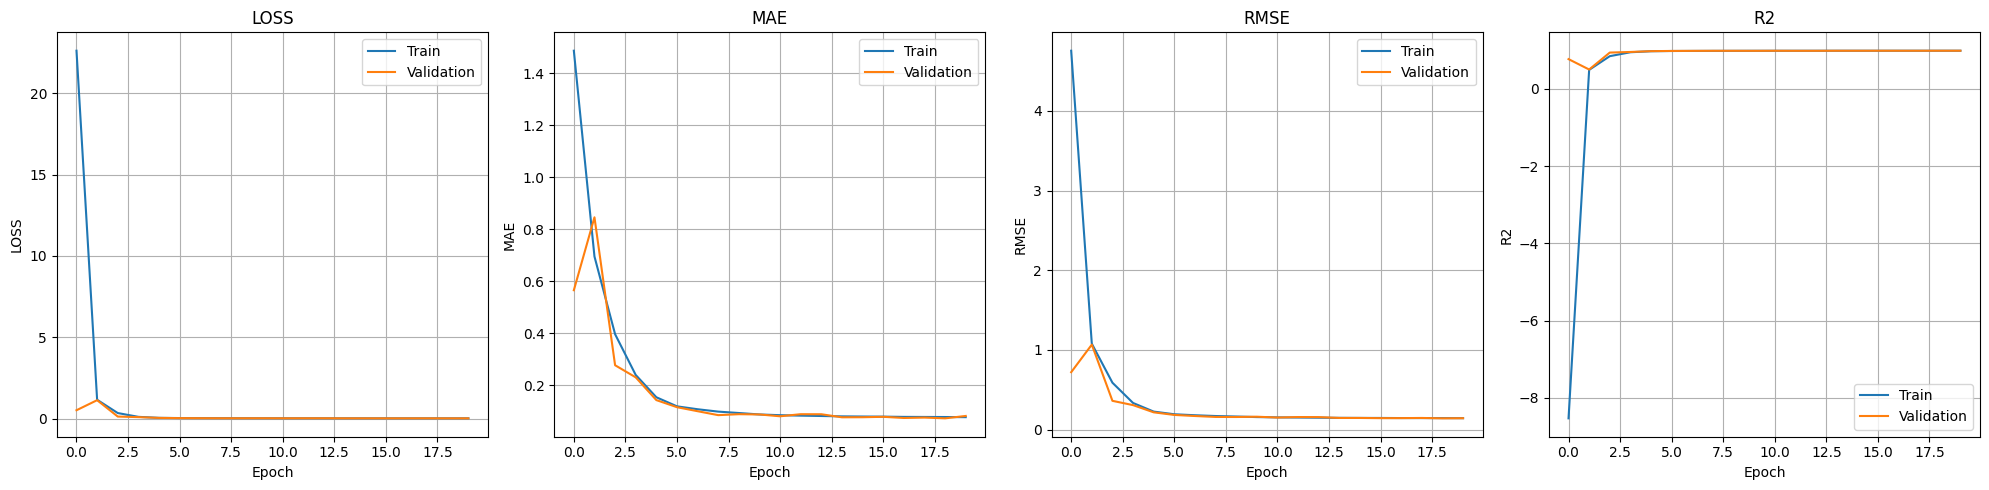

✅ Model saved as 'torcs_mlp_model.pth'

📊 Evaluation on Train Set
  MSE Loss     : 0.0201
  MAE          : 0.0818
  RMSE         : 0.1418
  R2 Score     : 0.9912

📊 Evaluation on Validation Set
  MSE Loss     : 0.0202
  MAE          : 0.0822
  RMSE         : 0.1421
  R2 Score     : 0.9911


In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# === Step 1: Load & Clean Data ===
df = pd.read_csv("Dataset.csv", low_memory=False)

# Strip column names (important!)
df.columns = df.columns.str.strip()

# Define target and feature columns
y_columns = ["Acceleration", "Braking", "Clutch", "Gear", "Steering"]
X_columns = [col for col in df.columns if col not in y_columns]

# Convert values to numeric, coercing errors to NaN
df[X_columns] = df[X_columns].apply(pd.to_numeric, errors='coerce')
df[y_columns] = df[y_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with any missing values
df = df.dropna()

# Convert to PyTorch tensors
X = torch.tensor(df[X_columns].values, dtype=torch.float32)
y = torch.tensor(df[y_columns].values, dtype=torch.float32)

# === Step 2: DataLoaders ===
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

# === Step 3: MLP Model ===
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X.shape[1], output_dim=len(y_columns))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === Step 4: Training with Metrics ===
EPOCHS = 20
history = {
    'train_loss': [], 'val_loss': [],
    'train_mae': [], 'val_mae': [],
    'train_rmse': [], 'val_rmse': [],
    'train_r2': [], 'val_r2': []
}

def calculate_r2(predictions, targets):
    """
    Calculates the R^2 score.

    Args:
        predictions (torch.Tensor): Predicted values.
        targets (torch.Tensor): Ground truth values.

    Returns:
        float: R^2 score.
    """
    sse = torch.sum((predictions - targets) ** 2)
    sst = torch.sum((targets - torch.mean(targets)) ** 2)
    r2 = 1 - (sse / sst)
    return r2.item()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_mae, train_r2 = 0, 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae += F.l1_loss(pred, yb).item()
        train_r2 += calculate_r2(pred, yb)


    model.eval()
    val_loss, val_mae, val_r2 = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
            val_mae += F.l1_loss(pred, yb).item()
            val_r2 += calculate_r2(pred, yb)

    train_rmse = (train_loss / len(train_loader))**0.5
    val_rmse = (val_loss / len(val_loader))**0.5

    # Save metrics
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(val_loader))
    history['train_mae'].append(train_mae / len(train_loader))
    history['val_mae'].append(val_mae / len(val_loader))
    history['train_rmse'].append(train_rmse)
    history['val_rmse'].append(val_rmse)
    history['train_r2'].append(train_r2 / len(train_loader))
    history['val_r2'].append(val_r2 / len(val_loader))

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {history['train_loss'][-1]:.4f}, MAE: {history['train_mae'][-1]:.4f}, RMSE: {train_rmse:.4f}, R2: {history['train_r2'][-1]:.4f} - "
          f"Val Loss: {history['val_loss'][-1]:.4f}, MAE: {history['val_mae'][-1]:.4f}, RMSE: {val_rmse:.4f}, R2: {history['val_r2'][-1]:.4f}")

# === Step 5: Plot Metrics ===
plt.figure(figsize=(20, 5))
metrics = ['loss', 'mae', 'rmse', 'r2']
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i + 1)
    plt.plot(history[f'train_{metric}'], label='Train')
    plt.plot(history[f'val_{metric}'], label='Validation')
    plt.title(metric.upper())
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# === Step 6: Save Model ===
torch.save(model.state_dict(), "torcs_mlp_model.pth")
print("✅ Model saved as 'torcs_mlp_model.pth'")

# === Step 8: Final Evaluation on Train and Validation Sets ===
def evaluate(loader, name="Dataset"):
    model.eval()
    total_loss, total_mae, total_r2 = 0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            total_loss += loss.item()
            total_mae += F.l1_loss(pred, yb).item()
            total_r2 += calculate_r2(pred, yb)

    avg_loss = total_loss / len(loader)
    avg_mae = total_mae / len(loader)
    avg_rmse = avg_loss ** 0.5
    avg_r2 = total_r2 / len(loader)

    print(f"\n📊 Evaluation on {name}")
    print(f"  MSE Loss     : {avg_loss:.4f}")
    print(f"  MAE          : {avg_mae:.4f}")
    print(f"  RMSE         : {avg_rmse:.4f}")
    print(f"  R2 Score     : {avg_r2:.4f}")

# Evaluate on both
evaluate(train_loader, name="Train Set")
evaluate(val_loader, name="Validation Set")
